In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

%matplotlib inline

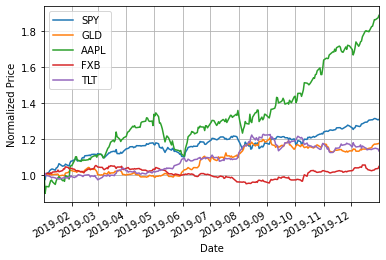

In [9]:
#  Import raw data downloaded from Yahoo finance
SPY  = pd.read_csv('SPY.csv')
GLD  = pd.read_csv('GLD.csv')
AAPL = pd.read_csv('AAPL.csv')
FXB  = pd.read_csv('FXB.csv')
TLT  = pd.read_csv('TLT.csv')

#  Convert the date column to DateTime objects
SPY['Date'] = pd.to_datetime(SPY['Date'])
GLD['Date'] = pd.to_datetime(GLD['Date'])
AAPL['Date'] = pd.to_datetime(AAPL['Date'])
FXB['Date'] = pd.to_datetime(FXB['Date'])
TLT['Date'] = pd.to_datetime(TLT['Date'])

#  Make the dates the frame's index
SPY.set_index('Date', inplace = True)
GLD.set_index('Date', inplace = True)
AAPL.set_index('Date', inplace = True)
FXB.set_index('Date', inplace = True)
TLT.set_index('Date', inplace = True)

#  Rename the Adj Close columns.  This is convenient when we build our new frames as the column names have to be unique
SPY = SPY.rename(columns = {'Adj Close': 'SPY'})
GLD = GLD.rename(columns = {'Adj Close': 'GLD'})
AAPL = AAPL.rename(columns = {'Adj Close': 'AAPL'})
FXB = FXB.rename(columns = {'Adj Close': 'FXB'})
TLT = TLT.rename(columns = {'Adj Close': 'TLT'})

#  Select our date range
date_range = pd.date_range('2019-01-01', '2019-12-31')
df = pd.DataFrame(index = date_range)
                  
#Build our new data frame
df = df.join(SPY['SPY'], how = 'inner')
df = df.join(GLD['GLD'], how = 'inner')
df = df.join(AAPL['AAPL'], how = 'inner')
df = df.join(FXB['FXB'], how = 'inner')
df = df.join(TLT['TLT'], how = 'inner')

#  Normalize the price data
df = df / df.iloc[0]

#  Plot the results
#print(df.head() )
ax = df.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.grid(True)

for part II, we will optimize on the Sharpe ratio:

$$S = \frac{E[R - r]}{E[R]}.  $$

where $R$ is the returns and $r$ is the risk-free rate.  For the sake of simplicity, we will take $r = 0$.  We won't bother with the conversion from daily to yearly rates of trun since this is only a scaling factor and won't affect the position of the maximum.

In [10]:
def portfolio_returns(alloc, data):
    data = data * alloc
    value = data.sum(axis = 1)
    value  = value[-1]
    
    #  Remember, the minus is because we want to maximize this function and our optimizer
    #  finds the minimum.
    return -value

def sharpe_ratio(alloc, data):
    data = data * alloc
    values = data.sum(axis = 1)
    daily_returns = values.pct_change().to_numpy()
    daily_returns = daily_returns[1:]
    
    return -np.mean(daily_returns) / np.std(daily_returns)

def constraint(alloc):
    return np.sum(alloc) - 1

bounds = ( (0,1), (0,1), (0,1), (0,1), (0,1) )

In [11]:
#  Set our initial guess and the constraint function.
alloc = [0.2, 0.2, 0.2, 0.2, 0.2]
cons = {'type':'eq', 'fun': constraint}

#  Do the optimization
a = minimize(portfolio_returns, alloc, args = df, bounds = bounds, constraints = cons)
print(a)

     fun: -1.8874243359683047
     jac: array([-1.31087483, -1.17777954, -1.88742433, -1.04977928, -1.13520499])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([2.22044605e-16, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])


In [12]:
#  Initial cguesses and constraint
alloc = [0.2, 0.2, 0.2, 0.2, 0.2]
cons = {'type':'eq', 'fun': constraint}

a = minimize(sharpe_ratio, alloc, args = df, bounds = bounds, constraints = cons)
print(a)

     fun: -0.2353969536658852
     jac: array([ 4.18540090e-04, -7.29421154e-04,  2.50060111e-05,  1.27423555e-05,
        1.62221491e-04])
 message: 'Optimization terminated successfully.'
    nfev: 58
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.27279512, 0.23653534, 0.15824569, 0.00425976, 0.32816409])
